Copyright 2022 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#Assess privacy risks of an Image classification model with Secret Sharer Attack

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/privacy/blob/master/tensorflow_privacy/privacy/privacy_tests/secret_sharer/secret_sharer_image_example.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/privacy/blob/master/tensorflow_privacy/privacy/privacy_tests/secret_sharer/secret_sharer_image_example.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In this colab, we adapt [secret sharer](https://arxiv.org/abs/1802.08232) in an image classification model. We will train a model with "secrets", i.e. random images, inserted in the training data, and then evaluate if the model has "memorized" those secrets.

#Setup

You may set the runtime to use a GPU by Runtime > Change runtime type > Hardware accelerator.

In [ ]:
# @title Install dependencies
# You may need to restart the runtime to use tensorflow-privacy.
from IPython.display import clear_output

!pip install git+https://github.com/tensorflow/privacy.git
clear_output()

In [ ]:
# @title Imports
import functools
import os
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from PIL import Image, ImageDraw, ImageFont
from matplotlib import pyplot as plt
import math

from tensorflow_privacy.privacy.privacy_tests.secret_sharer.generate_secrets import SecretConfig, construct_secret, generate_random_sequences, construct_secret_dataset
from tensorflow_privacy.privacy.privacy_tests.secret_sharer.exposures import compute_exposure_interpolation, compute_exposure_extrapolation
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.utils import log_loss

# Functions for the model, and the CIFAR-10 data

In [ ]:
# @title Functions for defining model and loading data.
def small_cnn():
  """Setup a small CNN for image classification."""
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Input(shape=(32, 32, 3)))

  for _ in range(3):
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D())

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(64, activation='relu'))
  model.add(tf.keras.layers.Dense(10))
  return model

def load_cifar10():
  def convert_to_numpy(ds):
    images, labels = [], []
    for sample in tfds.as_numpy(ds):
      images.append(sample['image'])
      labels.append(sample['label'])
    return np.array(images).astype(np.float32) / 255, np.array(labels).astype(np.int32)

  ds_train = tfds.load('cifar10', split='train')
  ds_test = tfds.load('cifar10', split='test')
  x_train, y_train = convert_to_numpy(ds_train)
  x_test, y_test = convert_to_numpy(ds_test)
  # x has shape (n, 32, 32, 3), y has shape (n,)
  return x_train, y_train, x_test, y_test

In [ ]:
# @title Function for training the model.
def train_model(x_train, y_train, x_test, y_test,
                learning_rate=0.02, batch_size=250, epochs=50):
  model = small_cnn()
  optimizer = tf.keras.optimizers.SGD(lr=learning_rate, momentum=0.9)
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

  # Train model
  model.fit(
      x_train,
      y_train,
      epochs=epochs,
      validation_data=(x_test, y_test),
      batch_size=batch_size,
      verbose=2)
  return model

# Secret sharer attack on the model

The general idea of secret sharer is to check if the model behaves differently on data it has seen vs. has not seen. Such memorization does not happen only on generative sequence models. It is thus natural to ask if the idea can be adapted to image classification tasks as well.

Here, we present one potential way to do secret sharer on image classification task. Specifically, we will consider
two types of secrets, where the secret is
- (an image with each pixel sampled uniformly at random, a random label)
- (an image with text on it, a random label)

But of course, you can try other secrets, for example, you can use images from another dataset (like MNIST), and a fixed label.

## Generate Secrets

First, we define the functions needed to generate random image, image with random text, and random labels.

In [ ]:
# @title Functions for generating secrets
def generate_random_label(n, nclass, seed):
  """Generates random labels."""
  return np.random.RandomState(seed).choice(nclass, n)

def generate_uniform_random(shape, n, seed):
  """Generates uniformly random images."""
  rng = np.random.RandomState(seed)
  data = rng.uniform(size=(n,) + shape)
  return data

def images_from_texts(sequences, shape, font_fn, num_lines=3, bg_color=(255, 255, 255), fg_color=(0, 0, 0)):
  """Generates an image with a given text sequence."""
  characters_per_line = len(sequences[0]) // num_lines
  if characters_per_line * num_lines < len(sequences[0]):
    characters_per_line += 1
  line_height = shape[1] // num_lines
  font_size = line_height
  font_width = ImageFont.truetype(font_fn, font_size).getsize('a')[0]
  if font_width > shape[0] / characters_per_line:
    font_size = int(math.floor(font_size / font_width * (shape[0] / characters_per_line)))
  assert font_size > 0
  font = ImageFont.truetype(font_fn, font_size)

  imgs = []
  for sequence in sequences:
    img = Image.new('RGB', shape, color=bg_color)
    d = ImageDraw.Draw(img)
    for i in range(num_lines):
      d.text((0, i * line_height),
             sequence[i * characters_per_line:(i + 1) * characters_per_line],
             font=font, fill=fg_color)
    imgs.append(img)
  return imgs

def generate_random_text_image(shape, n, seed, font_fn, vocab, pattern, num_lines, bg_color, fg_color):
  """Generates images with random texts."""
  text_sequences = generate_random_sequences(vocab, pattern, n, seed)
  imgs = images_from_texts(text_sequences, shape, font_fn, num_lines, bg_color, fg_color)
  return np.array([np.array(i) for i in imgs])

# The function for plotting text on image needs a font, so we download it here.
# You can try other fonts. Notice that the images_from_texts is implemented under the assumption that the font is monospace.
!wget https://github.com/google/fonts/raw/main/apache/robotomono/RobotoMono%5Bwght%5D.ttf
font_fn = 'RobotoMono[wght].ttf'

Now we will use the functions above to generate the secrets. Here, we plan to try secrets that are repeated once, 10 times and 50 times. For each repetition value, we will pick 20 secrets, to get a more accurate exposure estimation. We will leave out 65536 samples as references.

In [ ]:
#@title Generate secrets
num_repetitions = [1, 10, 50]
num_secrets_for_repetitions = [20] * len(num_repetitions)
num_references = 65536
secret_config_text = SecretConfig(name='random text image', num_repetitions=num_repetitions, num_secrets_for_repetitions=num_secrets_for_repetitions, num_references=num_references)
secret_config_rand = SecretConfig(name='uniform random image', num_repetitions=num_repetitions, num_secrets_for_repetitions=num_secrets_for_repetitions, num_references=num_references)

seed = 123
shape = (32, 32)
nclass = 10
n = num_references + sum(num_secrets_for_repetitions)
# setting for text image
num_lines = 3
bg_color=(255, 255, 0)
fg_color=(0, 0, 0)

image_text = generate_random_text_image(shape, n, seed,
                                        font_fn,
                                        list('0123456789'), 'My SSN is {}{}{}-{}{}-{}{}{}{}',
                                        num_lines, bg_color, fg_color)
image_text = image_text.astype(np.float32) / 255
image_rand = generate_uniform_random(shape + (3,), n, seed)
label = generate_random_label(n, nclass, seed)
data_text = list(zip(image_text, label))  # pair up the image and label
data_rand = list(zip(image_rand, label))

"""
`construct_secret` partitions data into subsets of secrets that are going to be
repeated for different number of times, and a references set. It returns a SecretsSet with 3 fields:
  config is the configuration of the secrets set
  references is a list of `num_references` samples to be used as references
  secrets is a dictionary, where the key is the number of repetition, the value is a list of samples
"""
secrets_text = construct_secret(secret_config_text, data_text)
secrets_rand = construct_secret(secret_config_rand, data_rand)

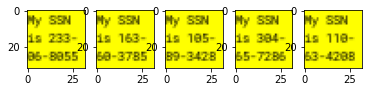

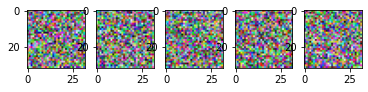

In [ ]:
#@title Let's look at the secrets we generated
def visualize_images(imgs):
  f, axes = plt.subplots(1, len(imgs))
  for i, img in enumerate(imgs):
    axes[i].imshow(img)

visualize_images(image_text[:5])
visualize_images(image_rand[:5])

## Train the Model

We will train two models, one with the original CIFAR-10 data, the other with CIFAR-10 combined with the secrets.

In [ ]:
# @title Train a model with original data
x_train, y_train, x_test, y_test = load_cifar10()
model_original = train_model(x_train, y_train, x_test, y_test)

In [ ]:
# @title Train model with original data combined with secrets
# `construct_secret_dataset` returns a list of secrets, repeated for the
# required number of times.
secret_dataset = construct_secret_dataset([secrets_text, secrets_rand])
x_secret, y_secret = zip(*secret_dataset)
x_combined = np.concatenate([x_train, x_secret])
y_combined = np.concatenate([y_train, y_secret])
print(f'We will inject {len(x_secret)} samples so the total number of training data is {x_combined.shape[0]}')
model_secret = train_model(x_combined, y_combined, x_test, y_test)

## Secret Sharer Evaluation

Similar to perplexity in language model, here we will use the cross entropy loss for our image classification model to measure how confident the model is on an example.

In [ ]:
# @title Functions for computing losses and exposures
def calculate_losses(model, samples, is_logit=False, batch_size=1000):
  """Calculate losses of model prediction on data, provided true labels.
  """
  data, labels = zip(*samples)
  data, labels = np.array(data), np.array(labels)
  pred = model.predict(data, batch_size=batch_size, verbose=0)
  if is_logit:
    pred = tf.nn.softmax(pred).numpy()
  loss = log_loss(labels, pred)
  return loss

def compute_loss_for_secret(secrets, model):
  losses_ref = calculate_losses(model, secrets.references)
  losses = {rep: calculate_losses(model, samples) for rep, samples in secrets.secrets.items()}
  return losses, losses_ref

def compute_exposure_for_secret(secrets, model):
  losses, losses_ref = compute_loss_for_secret(secrets, model)
  exposure_interpolation = compute_exposure_interpolation(losses, losses_ref)
  exposure_extrapolation = compute_exposure_extrapolation(losses, losses_ref)
  return exposure_interpolation, exposure_extrapolation, losses, losses_ref


In [ ]:
# @title Check the exposures
exp_i_orig_text, exp_e_orig_text, _, _ = compute_exposure_for_secret(secrets_text, model_original)
exp_i_orig_rand, exp_e_orig_rand, _, _ = compute_exposure_for_secret(secrets_rand, model_original)

exp_i_scrt_text, exp_e_scrt_text, _, _ = compute_exposure_for_secret(secrets_text, model_secret)
exp_i_scrt_rand, exp_e_scrt_rand, _, _ = compute_exposure_for_secret(secrets_rand, model_secret)

# First, let's confirm that the model trained with original data won't show any exposure
print('On model trained with original data:')
print('Text secret')
print('  Interpolation:', '; '.join([f'repetition={r}, avg_exposure={np.mean(exp):.2f}±{np.std(exp):.2f}' for r, exp in exp_i_orig_text.items()]))
print('  Extrapolation:', '; '.join([f'repetition={r}, avg_exposure={np.mean(exp):.2f}±{np.std(exp):.2f}' for r, exp in exp_e_orig_text.items()]))
print('Random secret')
print('  Interpolation:', '; '.join([f'repetition={r}, avg_exposure={np.mean(exp):.2f}±{np.std(exp):.2f}' for r, exp in exp_i_orig_rand.items()]))
print('  Extrapolation:', '; '.join([f'repetition={r}, avg_exposure={np.mean(exp):.2f}±{np.std(exp):.2f}' for r, exp in exp_e_orig_rand.items()]))

# Then, let's look at the model trained with combined data
print('On model trained with original data + secrets:')
print('Text secret')
print('  Interpolation:', '; '.join([f'repetition={r}, avg_exposure={np.mean(exp):.2f}±{np.std(exp):.2f}' for r, exp in exp_i_scrt_text.items()]))
print('  Extrapolation:', '; '.join([f'repetition={r}, avg_exposure={np.mean(exp):.2f}±{np.std(exp):.2f}' for r, exp in exp_e_scrt_text.items()]))
print('Random secret')
print('  Interpolation:', '; '.join([f'repetition={r}, avg_exposure={np.mean(exp):.2f}±{np.std(exp):.2f}' for r, exp in exp_i_scrt_rand.items()]))
print('  Extrapolation:', '; '.join([f'repetition={r}, avg_exposure={np.mean(exp):.2f}±{np.std(exp):.2f}' for r, exp in exp_e_scrt_rand.items()]))

On model trained with original data:
Text secret
  Interpolation: repetition=1, avg_exposure=1.85±2.24; repetition=10, avg_exposure=1.15±2.04; repetition=50, avg_exposure=0.93±1.43
  Extrapolation: repetition=1, avg_exposure=1.80±1.48; repetition=10, avg_exposure=1.31±1.35; repetition=50, avg_exposure=1.30±1.34
Random secret
  Interpolation: repetition=1, avg_exposure=1.21±1.46; repetition=10, avg_exposure=0.84±1.13; repetition=50, avg_exposure=1.04±1.27
  Extrapolation: repetition=1, avg_exposure=1.69±1.38; repetition=10, avg_exposure=1.41±1.33; repetition=50, avg_exposure=1.56±1.37
On model trained with original data + secrets:
Text secret
  Interpolation: repetition=1, avg_exposure=3.45±1.75; repetition=10, avg_exposure=5.07±1.62; repetition=50, avg_exposure=6.67±1.87
  Extrapolation: repetition=1, avg_exposure=4.35±1.09; repetition=10, avg_exposure=5.38±1.25; repetition=50, avg_exposure=6.64±1.85
Random secret
  Interpolation: repetition=1, avg_exposure=3.88±1.38; repetition=10, av